# Import helper_functions 

In [1]:
from helper_functions import (split_X_y, split_num_cat, forecasting_result, show_scores, APE, plot_histogram, 
                              fill_na_inf, calculating_kWh, plot_kWh, loss_acc_epochs, plot_pv, 
                              model_checkpoint, early_stop)

2024-02-20 14:13:40.859853: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-20 14:13:42.480902: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:7672] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-20 14:13:42.492364: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-20 14:13:42.492380: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1520] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-20 14:13:43.377259: I tensorflow/core/platform/cpu_feature_g

# Import historical dataset

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

original_df = pd.read_csv('../Data/hist_data.csv', 
                 index_col='timestamp_local', encoding='utf-8-sig', parse_dates=['timestamp_local'])

original_df.shape

(128832, 26)

In [3]:
'''
====================================
The imported dataset is already passed two preprocessing steps 

1. Remove timesteps with zero PV power output during daytime
2. Add sun position angles
====================================
'''
original_df.head(2)

,precip_rate,rh,wind_spd,timestamp_utc,snow_rate,app_temp,pres,azimuth,dewpt,uv,...,vis,dni,temp,slp,clouds,ts,PV_Power,declination_angle,altitude_angle,azimuth_angle
timestamp_local,,,,,,,,,,,,,,,,,,,,,
2016-01-04 00:00:00,0.0,61.0,1.6,2016-01-03 17:00:00,0.0,28.2,1014.76575,209.44,18.8,0.0,...,10.0,0.0,27.0,1015.0,25.0,1.451840e+09,0.0,-0.39703,-1.41642,0.00000
2016-01-04 00:15:00,0.0,63.0,1.6,2016-01-03 17:15:00,0.0,28.3,1014.76570,191.08,19.4,0.0,...,10.0,0.0,27.0,1015.0,25.0,1.451841e+09,0.0,-0.39703,-1.40442,0.37278


# Preprocessing data
## 1. Filter daytime timestamp

### 1.1 Advance filter

In [4]:
import datetime
hours = original_df.index.time
advance_filter = ((hours == datetime.time(0,0)) | (hours == datetime.time(1,0)) | (hours == datetime.time(2,0)) | 
                  (hours == datetime.time(3,0)) | (hours == datetime.time(4,0)) | (hours == datetime.time(5,0)) |
                  (hours >= datetime.time(6,0)) & (hours <= datetime.time(18,0)) | (hours == datetime.time(19,0)) | 
                  (hours == datetime.time(20,0)) | (hours == datetime.time(21,0)) |(hours == datetime.time(22,0)) |
                  (hours == datetime.time(23,0)))
len(advance_filter)

128832

In [5]:
adv_fil_df = original_df[advance_filter]
adv_fil_df.shape

(80520, 26)

### 1.2 Standard filter

In [6]:
import datetime
std_fil_df = original_df[(original_df.index.time >= datetime.time(6,0)) & (original_df.index.time <= datetime.time(18,0))]
std_fil_df.shape

(65758, 26)

In [7]:
# adv_fil_df.loc["2016-04-04":"2016-04-06"]['PV_Power'].plot();

In [8]:
print(f'Advance filter has {adv_fil_df.shape[0]} samples, presenting {(adv_fil_df.shape[0] * 100 / original_df.shape[0]):.2f} % from original df')
print(f'Standard filter has {std_fil_df.shape[0]} samples, presenting {(std_fil_df.shape[0] * 100 / original_df.shape[0]):.2f} % from original df \n')

print(f'Advance filter df => {adv_fil_df.loc["2016-01-04"].shape[0]} samples per day')
print(f'Standard filter df => {std_fil_df.loc["2016-01-04"].shape[0]} samples per day')


'''
Choose which filter dfs.
'''
# df = adv_fil_df
df = std_fil_df
# df = original_df

Advance filter has 80520 samples, presenting 62.50 % from original df
Standard filter has 65758 samples, presenting 51.04 % from original df 

Advance filter df => 60 samples per day
Standard filter df => 49 samples per day


## 2. Features selections and arrange columns to extract spatial features 

In [9]:
'''
Arrange correlated columns:

`Irradiance` => `Temperatures` => `visibility` => 'Wind & humidity' => 'Sun Position' => 'PV_Power (y)' => Unused columns

'''
arr_cols = ['solar_rad', 'ghi', 'dhi', 'dni', 'uv', 'rh',       
            'app_temp', 'temp', 'dewpt', 
            'clouds', 'vis',             
            'wind_spd', 'wind_dir', 
            'declination_angle', 'altitude_angle', 'azimuth_angle',
            'PV_Power',
            'weather', 'precip_rate',   'timestamp_utc', 'snow_rate', 'pres', 'azimuth', 'elev_angle', 'slp', 'ts']

df = df[arr_cols]
df.columns

Index(['solar_rad', 'ghi', 'dhi', 'dni', 'uv', 'rh', 'app_temp', 'temp',
       'dewpt', 'clouds', 'vis', 'wind_spd', 'wind_dir', 'declination_angle',
       'altitude_angle', 'azimuth_angle', 'PV_Power', 'weather', 'precip_rate',
       'timestamp_utc', 'snow_rate', 'pres', 'azimuth', 'elev_angle', 'slp',
       'ts'],
      dtype='object')

In [10]:
# Split X columns into categorical and numerical 
categorical_columns, numerical_columns = split_num_cat(df)
print(f'Categorical columns : {categorical_columns} \n')
print(f'Numerical columns : {numerical_columns}')

Categorical columns : ['weather', 'timestamp_utc'] 

Numerical columns : ['solar_rad', 'ghi', 'dhi', 'dni', 'uv', 'rh', 'app_temp', 'temp', 'dewpt', 'clouds', 'vis', 'wind_spd', 'wind_dir', 'declination_angle', 'altitude_angle', 'azimuth_angle', 'PV_Power', 'precip_rate', 'snow_rate', 'pres', 'azimuth', 'elev_angle', 'slp', 'ts']


In [11]:
'''
Selecte columns which will not be passed to forecasting models
'''
y_col = ['PV_Power']

ignored_cols = ['dewpt', 'clouds', 'vis', 'precip_rate', 'azimuth', 'elev_angle', 
                'snow_rate', 'ts', 'pres', 'wind_dir', 'slp'] + categorical_columns 

# ignored_cols = ['precip_rate', 'azimuth', 'elev_angle', 
#                 'snow_rate', 'ts', 'pres', 'wind_dir', 'slp'] + categorical_columns 
print(f'Ignored columns : {ignored_cols}')

Ignored columns : ['dewpt', 'clouds', 'vis', 'precip_rate', 'azimuth', 'elev_angle', 'snow_rate', 'ts', 'pres', 'wind_dir', 'slp', 'weather', 'timestamp_utc']


In [12]:
# Split datasets by time
training_set = df.sort_index().loc[:'2018-09'] # Training set (2 years and 9 months) = 68%
val_set = df.sort_index().loc['2018-10':'2018-12'] # Validation set (3 months) = 7%
test_set = df.sort_index().loc['2019':] # Test set (1 year) = 25%

# Split `X` and `y`
X_train, y_train = split_X_y(training_set, ignored_cols)
X_val, y_val = split_X_y(val_set, ignored_cols)
X_test, y_test = split_X_y(test_set, ignored_cols)


X_cols = X_train.columns
print(f'List of X columns: \n{list(X_cols)} \n')
print(f'Total of X columns: \n{len(X_cols)}')

List of X columns: 
['solar_rad', 'ghi', 'dhi', 'dni', 'uv', 'rh', 'app_temp', 'temp', 'wind_spd', 'declination_angle', 'altitude_angle', 'azimuth_angle'] 

Total of X columns: 
12


In [13]:
## Time peroid of each dataset. 
print(
    f'''
    Training set is from {X_train.index.min()} to {X_train.index.max()} 
    Validation set is from {X_val.index.min()} to {X_val.index.max()} 
    Test set is from {X_test.index.min()} to {X_test.index.max()}
    ''')


    Training set is from 2016-01-04 06:00:00 to 2018-09-30 18:00:00 
    Validation set is from 2018-10-01 06:00:00 to 2018-12-31 18:00:00 
    Test set is from 2019-01-01 06:00:00 to 2019-12-31 18:00:00
    


## 3. Rescale numerical columns

In [14]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MaxAbsScaler

# Manage columns for Standardize processes
non_std_cols = ['declination_angle', 'altitude_angle', 'azimuth_angle']

selected_cols = list(map(lambda x : x not in non_std_cols, X_cols))
std_cols = X_cols[selected_cols]
print(f'Total of columns to rescale: \n{len(std_cols)}')
print(f'Columns to rescale are: {list(std_cols)} \n')

ct = make_column_transformer((MaxAbsScaler(), std_cols), remainder='passthrough')

ct.fit(X_train)

std_X_train = ct.transform(X_train)
std_X_val = ct.transform(X_val)
std_X_test = ct.transform(X_test)

std_X_train.shape, y_train.shape, std_X_val.shape, y_val.shape, std_X_test.shape, y_test.shape

Total of columns to rescale: 
9
Columns to rescale are: ['solar_rad', 'ghi', 'dhi', 'dni', 'uv', 'rh', 'app_temp', 'temp', 'wind_spd'] 



((44982, 12), (44982,), (4312, 12), (4312,), (16464, 12), (16464,))

In [15]:
'''
Check data type of all dataset
'''
std_X_train.dtype, y_train.dtype, std_X_val.dtype, y_val.dtype, std_X_test.dtype, y_test.dtype

(dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'))

In [16]:
print(f"training set = {np.round(std_X_train.shape[0] / df.shape[0], 2)}")
print(f"validation set = {np.round(std_X_val.shape[0] / df.shape[0], 2)}")
print(f"test set = {np.round(std_X_test.shape[0] / df.shape[0], 2)}")
print(f'total datapoints = {std_X_train.shape[0] + std_X_val.shape[0] + std_X_test.shape[0]}')

training set = 0.68
validation set = 0.07
test set = 0.25
total datapoints = 65758


In [17]:
'''
Testing normalize process
'''
print(f'Total samples in a day = {df.loc["2016-01-04"].shape[0]}')

Total samples in a day = 49


In [18]:
# pd.DataFrame(std_X_train).iloc[:147, -1].plot();

### Save Column Transformer and features columns for further uses

In [19]:
from joblib import dump, load

'''
============================================
Save Column Transformer and features columns
============================================
'''

# dump(ct, './joblib_files/ct.joblib')
# dump(X_cols, './joblib_files/X_cols.joblib')

'\n============================================\nSave Column Transformer and features columns\n============================================\n'

# Setup environment and sequence data
## 1. Check CPU and GPU available

In [20]:
import tensorflow as tf
from tensorflow import keras
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Tensorflow version = " + tf.__version__)

Num GPUs Available:  1
Tensorflow version = 2.14.0-dev20230509


## 2. Set random seed and state

In [21]:
import os, random
import tensorflow as tf

def set_seed(seed_value=20):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

# Building DL models

## 1. `Multilayers Perceptron (MLP)` 

In [54]:
from keras import Model
from keras.layers import Dense, BatchNormalization, Dropout, Flatten, Activation, Input
from keras.optimizers import SGD, Adam
from keras.callbacks import ReduceLROnPlateau
from keras.metrics import RootMeanSquaredError

set_seed()

# Structure model
inputs = Input(shape=(std_X_train.shape[1]), name='model_input')

x = Dense(96, activation='relu', name='1st_dense')(inputs)
x = BatchNormalization()(x)
x = Dense(48, activation='relu', name='2nd_dense')(x)
x = BatchNormalization()(x)
x = Dense(24, activation='tanh', name='3rd_dense')(x)
x = BatchNormalization()(x)


# x = Dropout(0.1)(x)
# x = Dense(8, activation='relu', name='4th_dense')(x)
# x = Dense(24, activation='relu', name='5th_dense')(x)

output = Dense(1, activation='relu', name='model_output')(x)
MLP_model = Model(inputs=inputs, outputs=output, name='MLP_model')

# Configure optimizer
lr_scheduler = tf.keras.optimizers.schedules.InverseTimeDecay(0.001, decay_rate=1e-6, decay_steps=1, staircase=False)
opt = Adam(learning_rate=lr_scheduler)

# Define an optimizer and loss metric
MLP_model.compile(optimizer=opt, loss='mean_absolute_error', metrics=['mean_absolute_error'])

MLP_model.summary()

Model: "MLP_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_input (InputLayer)    [(None, 12)]              0         
                                                                 
 1st_dense (Dense)           (None, 96)                1248      
                                                                 
 batch_normalization_6 (Bat  (None, 96)                384       
 chNormalization)                                                
                                                                 
 2nd_dense (Dense)           (None, 48)                4656      
                                                                 
 batch_normalization_7 (Bat  (None, 48)                192       
 chNormalization)                                                
                                                                 
 3rd_dense (Dense)           (None, 16)                78

In [55]:
'''
===================
Initial train model 
===================
'''
init_epochs = 150
Batch = 32

with tf.device('/GPU:0'):
    MLP_history = MLP_model.fit(x=std_X_train, y=y_train, 
                                epochs=init_epochs, batch_size=Batch, 
                                validation_data=(std_X_val, y_val), verbose=1,
                                callbacks=[early_stop('val_loss', 10)])
    
# with tf.device('/GPU:0'):
#     MLP_history = MLP_model.fit(x=std_X_train, y=y_train, 
#                                 epochs=init_epochs, batch_size=Batch, 
#                                 validation_data=(std_X_val, y_val), verbose=1,
#                                 callbacks=[early_stop('val_loss', 10), model_checkpoint('go_beyond2_MLP')])

The model is saved in "saved_models/go_beyond4_MLP"
Epoch 1/150
1406/1406 [==============================] - ETA: 0s - loss: 2937.2502 - mean_absolute_error: 2937.2502INFO:tensorflow:Assets written to: saved_models/go_beyond4_MLP/assets


INFO:tensorflow:Assets written to: saved_models/go_beyond4_MLP/assets


1406/1406 [==============================] - 29s 6ms/step - loss: 2937.2502 - mean_absolute_error: 2937.2502 - val_loss: 2415.1873 - val_mean_absolute_error: 2415.1873
Epoch 2/150
1393/1406 [============================>.] - ETA: 0s - loss: 2773.0667 - mean_absolute_error: 2773.0667INFO:tensorflow:Assets written to: saved_models/go_beyond4_MLP/assets


INFO:tensorflow:Assets written to: saved_models/go_beyond4_MLP/assets


1406/1406 [==============================] - 6s 4ms/step - loss: 2771.3552 - mean_absolute_error: 2771.3552 - val_loss: 2195.1968 - val_mean_absolute_error: 2195.1968
Epoch 3/150
1393/1406 [============================>.] - ETA: 0s - loss: 2506.9946 - mean_absolute_error: 2506.9946INFO:tensorflow:Assets written to: saved_models/go_beyond4_MLP/assets


INFO:tensorflow:Assets written to: saved_models/go_beyond4_MLP/assets


1406/1406 [==============================] - 6s 4ms/step - loss: 2503.7944 - mean_absolute_error: 2503.7944 - val_loss: 1942.5433 - val_mean_absolute_error: 1942.5433
Epoch 4/150
1393/1406 [============================>.] - ETA: 0s - loss: 2185.4780 - mean_absolute_error: 2185.4780INFO:tensorflow:Assets written to: saved_models/go_beyond4_MLP/assets


INFO:tensorflow:Assets written to: saved_models/go_beyond4_MLP/assets


1406/1406 [==============================] - 11s 8ms/step - loss: 2183.1484 - mean_absolute_error: 2183.1484 - val_loss: 1643.3604 - val_mean_absolute_error: 1643.3604
Epoch 5/150
1395/1406 [============================>.] - ETA: 0s - loss: 1826.4897 - mean_absolute_error: 1826.4897INFO:tensorflow:Assets written to: saved_models/go_beyond4_MLP/assets


INFO:tensorflow:Assets written to: saved_models/go_beyond4_MLP/assets


1406/1406 [==============================] - 14s 8ms/step - loss: 1823.4260 - mean_absolute_error: 1823.4260 - val_loss: 1230.1339 - val_mean_absolute_error: 1230.1339
Epoch 6/150
1399/1406 [============================>.] - ETA: 0s - loss: 1446.1241 - mean_absolute_error: 1446.1241INFO:tensorflow:Assets written to: saved_models/go_beyond4_MLP/assets


INFO:tensorflow:Assets written to: saved_models/go_beyond4_MLP/assets


1406/1406 [==============================] - 7s 5ms/step - loss: 1446.8710 - mean_absolute_error: 1446.8710 - val_loss: 749.8766 - val_mean_absolute_error: 749.8766
Epoch 7/150
1393/1406 [============================>.] - ETA: 0s - loss: 1124.6891 - mean_absolute_error: 1124.6891INFO:tensorflow:Assets written to: saved_models/go_beyond4_MLP/assets


INFO:tensorflow:Assets written to: saved_models/go_beyond4_MLP/assets


1406/1406 [==============================] - 6s 4ms/step - loss: 1123.2787 - mean_absolute_error: 1123.2787 - val_loss: 627.8336 - val_mean_absolute_error: 627.8336
Epoch 8/150
1393/1406 [============================>.] - ETA: 0s - loss: 925.5530 - mean_absolute_error: 925.5530INFO:tensorflow:Assets written to: saved_models/go_beyond4_MLP/assets


INFO:tensorflow:Assets written to: saved_models/go_beyond4_MLP/assets


1406/1406 [==============================] - 6s 4ms/step - loss: 924.8879 - mean_absolute_error: 924.8879 - val_loss: 604.3704 - val_mean_absolute_error: 604.3704
Epoch 9/150
1406/1406 [==============================] - 5s 3ms/step - loss: 855.6148 - mean_absolute_error: 855.6148 - val_loss: 682.3800 - val_mean_absolute_error: 682.3800
Epoch 10/150
1406/1406 [==============================] - 5s 3ms/step - loss: 837.2184 - mean_absolute_error: 837.2184 - val_loss: 604.8865 - val_mean_absolute_error: 604.8865
Epoch 11/150
1406/1406 [==============================] - 5s 3ms/step - loss: 826.3691 - mean_absolute_error: 826.3691 - val_loss: 621.4023 - val_mean_absolute_error: 621.4023
Epoch 12/150
1406/1406 [==============================] - 5s 3ms/step - loss: 817.4908 - mean_absolute_error: 817.4908 - val_loss: 634.5106 - val_mean_absolute_error: 634.5106
Epoch 13/150
1406/1406 [==============================] - 5s 3ms/step - loss: 816.4916 - mean_absolute_error: 816.4916 - val_loss: 631

INFO:tensorflow:Assets written to: saved_models/go_beyond4_MLP/assets


1406/1406 [==============================] - 11s 8ms/step - loss: 813.7645 - mean_absolute_error: 813.7645 - val_loss: 594.2321 - val_mean_absolute_error: 594.2321
Epoch 16/150
1406/1406 [==============================] - 13s 7ms/step - loss: 813.3098 - mean_absolute_error: 813.3098 - val_loss: 629.5172 - val_mean_absolute_error: 629.5172
Epoch 17/150
1398/1406 [============================>.] - ETA: 0s - loss: 808.2564 - mean_absolute_error: 808.2564INFO:tensorflow:Assets written to: saved_models/go_beyond4_MLP/assets


INFO:tensorflow:Assets written to: saved_models/go_beyond4_MLP/assets


1406/1406 [==============================] - 6s 4ms/step - loss: 808.1724 - mean_absolute_error: 808.1724 - val_loss: 588.9297 - val_mean_absolute_error: 588.9297
Epoch 18/150
1406/1406 [==============================] - 5s 3ms/step - loss: 808.0447 - mean_absolute_error: 808.0447 - val_loss: 604.5239 - val_mean_absolute_error: 604.5239
Epoch 19/150
1406/1406 [==============================] - 5s 3ms/step - loss: 809.3763 - mean_absolute_error: 809.3763 - val_loss: 658.0130 - val_mean_absolute_error: 658.0130
Epoch 20/150
1406/1406 [==============================] - 5s 3ms/step - loss: 808.3229 - mean_absolute_error: 808.3229 - val_loss: 635.2587 - val_mean_absolute_error: 635.2587
Epoch 21/150
1406/1406 [==============================] - 5s 3ms/step - loss: 804.4406 - mean_absolute_error: 804.4406 - val_loss: 665.7999 - val_mean_absolute_error: 665.7999
Epoch 22/150
1406/1406 [==============================] - 5s 3ms/step - loss: 806.4161 - mean_absolute_error: 806.4161 - val_loss: 71

In [173]:
# set_seed()

# '''
# =====================================
# Train model with callbacks functions
# =====================================
# '''
# checkpoint_epochs = init_epochs + 20
# Batch = 32

# with tf.device('/GPU:0'):
#     MLP_checkpoint_history = MLP_model.fit(x=std_X_train, y=y_train,
#                                            epochs=checkpoint_epochs, initial_epoch=init_epochs,
#                                            batch_size=Batch, validation_data=(std_X_val, y_val),
#                                            verbose=1, callbacks=[early_stop('val_loss', 3), 
#                                                                  model_checkpoint('new_MLP')])

### Saved model

- `go_beyond_3 is the one!!! so far`

x = Dense(96, activation='relu', name='1st_dense')(inputs)
x = BatchNormalization()(x)
x = Dense(48, activation='relu', name='2nd_dense')(x)
x = BatchNormalization()(x)
x = Dense(24, activation='tanh', name='3rd_dense')(x)
x = BatchNormalization()(x)

- Trained at 23 epochs with early stop and model_checkpoint


In [22]:
# Save the model
# MLP_model.save('saved_models/MLP_model3')

# load the model
MLP_model = keras.models.load_model('saved_models/go_beyond3_MLP/')

2024-02-20 14:14:08.425936: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18211 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB MIG 3g.20gb, pci bus id: 0000:98:00.0, compute capability: 8.0


## Forecast and Evaluation results

### PV power forecasting

In [23]:
MLP_val_result = forecasting_result(MLP_model, std_X_val)
MLP_test_result = forecasting_result(MLP_model, std_X_test)

2024-02-20 14:14:26.139788: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


515/515 [==============================] - 2s 2ms/step


In [24]:
MLP_val_scores = show_scores(MLP_val_result, y_val)

Mean Absolute Error = 559.38 W 
Root Mean Squared Error = 870.75 W 
Mean Bias Error = 126.19 W 
 
Normalized_MAE (installed_Power) = 5.59% 
Normalized_RMSE (installed_Power) = 8.71% 
 
Normalized_MAE (avg_Power) = 22.23% 
Normalized_RMSE (avg_Power) = 34.61% 
 
Peak PV output power (from y_test) = 7888.33 W 
Average PV output power (from y_test) = 2515.80 W


In [25]:
MLP_test_scores = show_scores(MLP_test_result, y_test)

Mean Absolute Error = 694.76 W 
Root Mean Squared Error = 999.50 W 
Mean Bias Error = -36.30 W 
 
Normalized_MAE (installed_Power) = 6.95% 
Normalized_RMSE (installed_Power) = 9.99% 
 
Normalized_MAE (avg_Power) = 22.71% 
Normalized_RMSE (avg_Power) = 32.67% 
 
Peak PV output power (from y_test) = 9875.00 W 
Average PV output power (from y_test) = 3059.60 W


## Plot loss vs Epochs

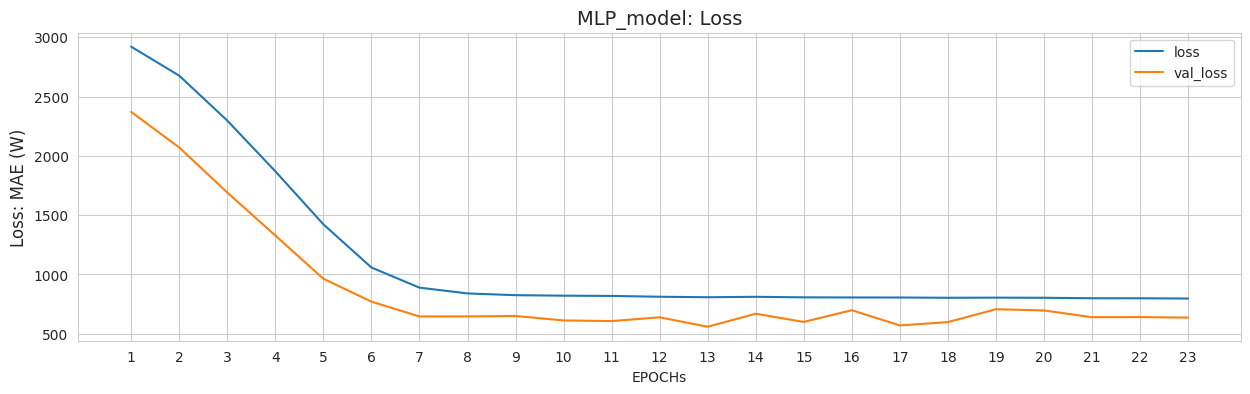

In [29]:
loss_acc_epochs(MLP_history, model_name='MLP_model', loss_name='MAE (W)')

In [30]:
# Save loss vs epoch
# pd.DataFrame(MLP_history.history).to_csv('data_for_report/MLP_loss_epoch (30 epochs).csv')

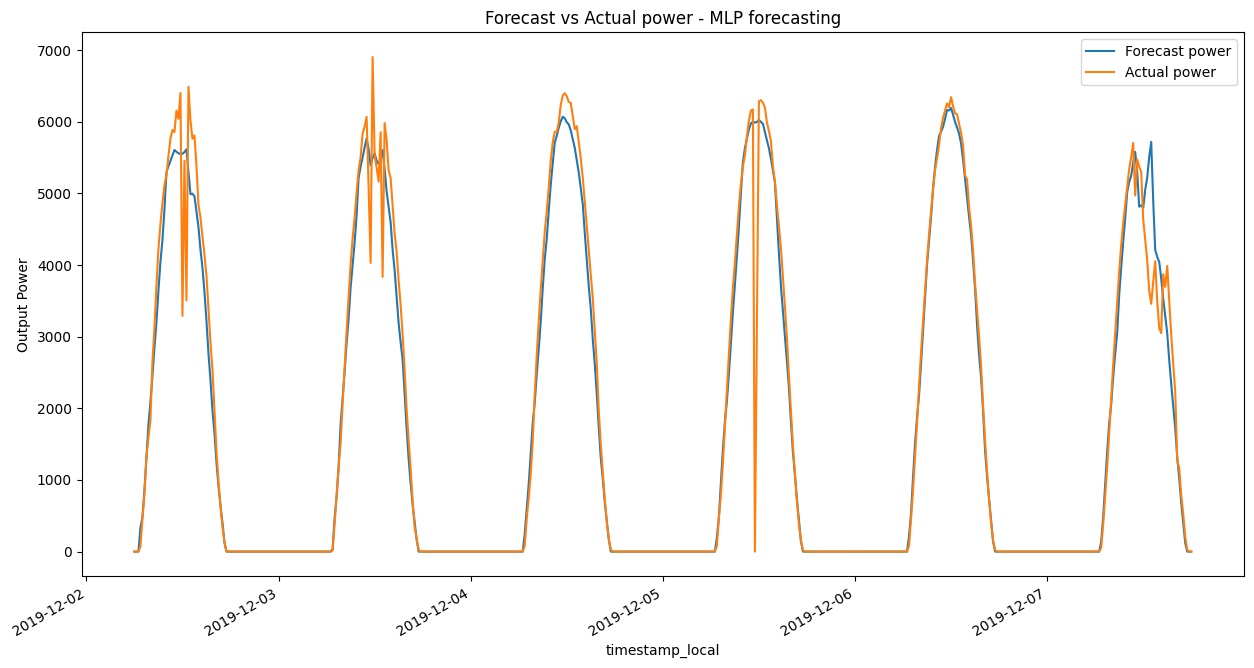

In [26]:
plot_pv(MLP_test_result, y_test, 'MLP', {'year':2019, 'month':12, 'start':3, 'end':8})

# Build ML models (baseline models)

## `1. RandomForest`

In [27]:
from sklearn.ensemble import RandomForestRegressor

set_seed()

# Hyperparameter of RandomForest model is from `sararut_chayanont report, page 17`
RF_model = RandomForestRegressor(n_jobs=-1, random_state=20, n_estimators=500, 
                                max_depth=10, min_samples_leaf=16,
                                min_samples_split=34)

## Note: with the new experiment, n_estimators 1000 don't increase accuracy, so stick at 500

In [28]:
RF_model.fit(std_X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=16, min_samples_split=34,
                      n_estimators=500, n_jobs=-1, random_state=20)

### Save and load model

In [27]:
from joblib import dump, load

# save model
# dump(RF_model, 'saved_models/go_beyond_RF.joblib')

# load model 
RF_model = load('saved_models/go_beyond_RF.joblib')

## Forecast and Evaluation results

In [28]:
RF_val_result = forecasting_result(RF_model, std_X_val)
RF_test_result = forecasting_result(RF_model, std_X_test)

In [29]:
RF_val_scores = show_scores(RF_val_result, y_val)

Mean Absolute Error = 584.08 W 
Root Mean Squared Error = 923.69 W 
Mean Bias Error = 225.38 W 
 
Normalized_MAE (installed_Power) = 5.84% 
Normalized_RMSE (installed_Power) = 9.24% 
 
Normalized_MAE (avg_Power) = 23.22% 
Normalized_RMSE (avg_Power) = 36.72% 
 
Peak PV output power (from y_test) = 7888.33 W 
Average PV output power (from y_test) = 2515.80 W


In [30]:
RF_test_scores = show_scores(RF_test_result, y_test)

Mean Absolute Error = 690.03 W 
Root Mean Squared Error = 1008.22 W 
Mean Bias Error = 58.85 W 
 
Normalized_MAE (installed_Power) = 6.90% 
Normalized_RMSE (installed_Power) = 10.08% 
 
Normalized_MAE (avg_Power) = 22.55% 
Normalized_RMSE (avg_Power) = 32.95% 
 
Peak PV output power (from y_test) = 9875.00 W 
Average PV output power (from y_test) = 3059.60 W


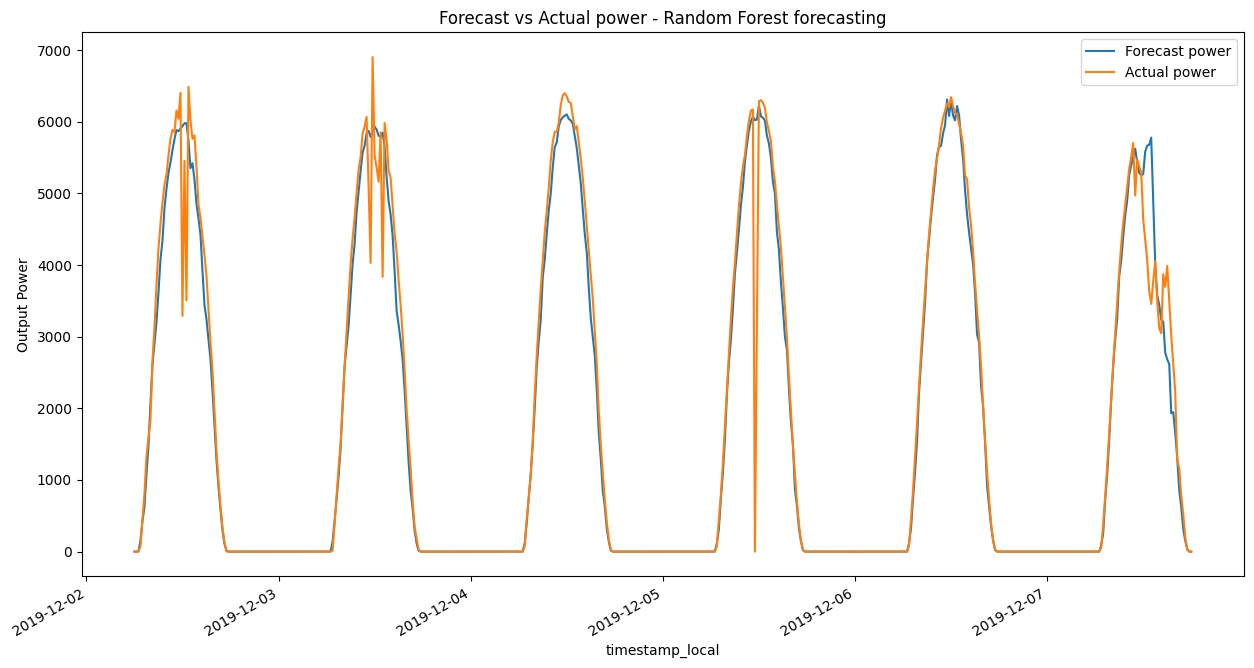

In [31]:
plot_pv(RF_test_result, y_test, 'Random Forest', {'year':2019, 'month':12, 'start':3, 'end':8})

## `2. SVM`

**note** LinearSVR and SVR give the same result, but LinearSVR is a lot quicker to train (suitable for big data). As the result, LinearSVR is employed in this study

In [34]:
from sklearn.svm import LinearSVR, SVR

set_seed()
SVR_model = LinearSVR(C=5.0, epsilon=1.0)
# SVR_model = SVR(kernel='linear', C=5.0, epsilon=1.0)

In [35]:
SVR_model.fit(std_X_train, y_train)

LinearSVR(C=5.0, epsilon=1.0)

### Save and load model

In [32]:
from joblib import dump, load

# save model
# dump(SVR_model, 'saved_models/go_beyond_SVR.joblib')

# load model 
SVR_model = load('saved_models/go_beyond_SVR.joblib')

## Forecast and Evaluation results

In [33]:
SVR_val_result = forecasting_result(SVR_model, std_X_val)
SVR_test_result = forecasting_result(SVR_model, std_X_test)

In [34]:
SVR_val_scores = show_scores(SVR_val_result, y_val)

Mean Absolute Error = 691.08 W 
Root Mean Squared Error = 1012.07 W 
Mean Bias Error = 280.39 W 
 
Normalized_MAE (installed_Power) = 6.91% 
Normalized_RMSE (installed_Power) = 10.12% 
 
Normalized_MAE (avg_Power) = 27.47% 
Normalized_RMSE (avg_Power) = 40.23% 
 
Peak PV output power (from y_test) = 7888.33 W 
Average PV output power (from y_test) = 2515.80 W


In [35]:
SVR_test_scores = show_scores(SVR_test_result, y_test)

Mean Absolute Error = 784.07 W 
Root Mean Squared Error = 1077.07 W 
Mean Bias Error = 112.13 W 
 
Normalized_MAE (installed_Power) = 7.84% 
Normalized_RMSE (installed_Power) = 10.77% 
 
Normalized_MAE (avg_Power) = 25.63% 
Normalized_RMSE (avg_Power) = 35.20% 
 
Peak PV output power (from y_test) = 9875.00 W 
Average PV output power (from y_test) = 3059.60 W


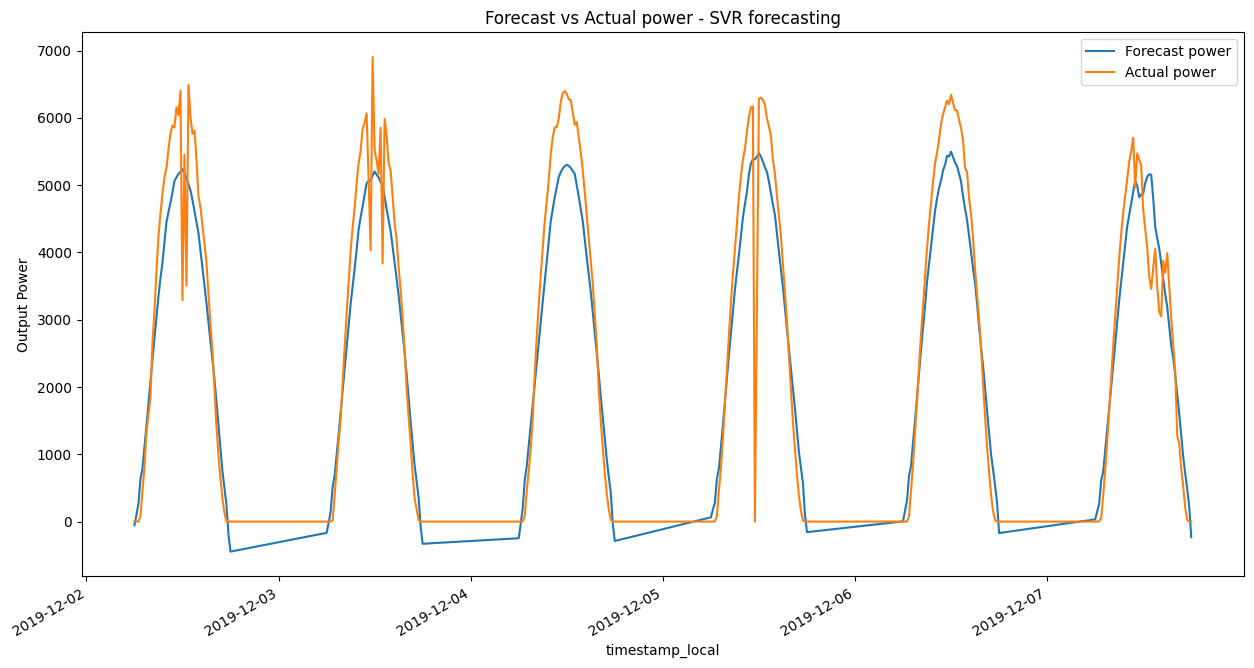

In [36]:
plot_pv(SVR_test_result, y_test, 'SVR', {'year':2019, 'month':12, 'start':3, 'end':8})

## Comparing the model's accuracy

### 1. PV power

In [37]:
NWP_model_scores = pd.DataFrame([MLP_test_scores, RF_test_scores, SVR_test_scores], 
                            index=['MLP', 'RF', 'SVM']).round(2)

NWP_model_scores

,MAE,RMSE,MBE,NMAE_installed,NRMSE_installed,NMAE_avg,NRMSE_avg
MLP,694.76,999.50,-36.30,6.95,9.99,22.71,32.67
RF,690.03,1008.22,58.85,6.90,10.08,22.55,32.95
SVM,784.07,1077.07,112.13,7.84,10.77,25.63,35.20


In [38]:
NWP_model_results = pd.concat([y_test.reset_index(), pd.Series(MLP_test_result),
                               pd.Series(RF_test_result), pd.Series(SVR_test_result)], axis=1)

NWP_model_results = NWP_model_results.set_index('timestamp_local')
NWP_model_results.columns = ['Actual', 'MLP', 'RandomForest', 'SVM']
NWP_model_results.head(55)

,Actual,MLP,RandomForest,SVM
timestamp_local,,,,
2019-01-01 06:00:00,0.000000,0.000000,0.063474,-158.713314
2019-01-01 06:15:00,0.000000,0.000000,0.063474,-53.125991
2019-01-01 06:30:00,0.000000,0.000000,0.063474,51.418011
2019-01-01 06:45:00,2.666667,0.000000,3.061135,177.333259
2019-01-01 07:00:00,57.333332,0.000000,118.539528,425.101960
2019-01-01 07:15:00,169.666672,452.242798,421.009435,710.937350
2019-01-01 07:30:00,516.666687,772.258423,662.231223,995.381665
2019-01-01 07:45:00,761.000000,1201.916382,1042.892567,1288.223098
2019-01-01 08:00:00,1704.000000,1824.545288,1515.357027,1579.868945


In [39]:
'''
Save the results in csv.
'''
NWP_model_results.to_csv('./data_for_report/forecast_result-Test_set_model1-3.csv')

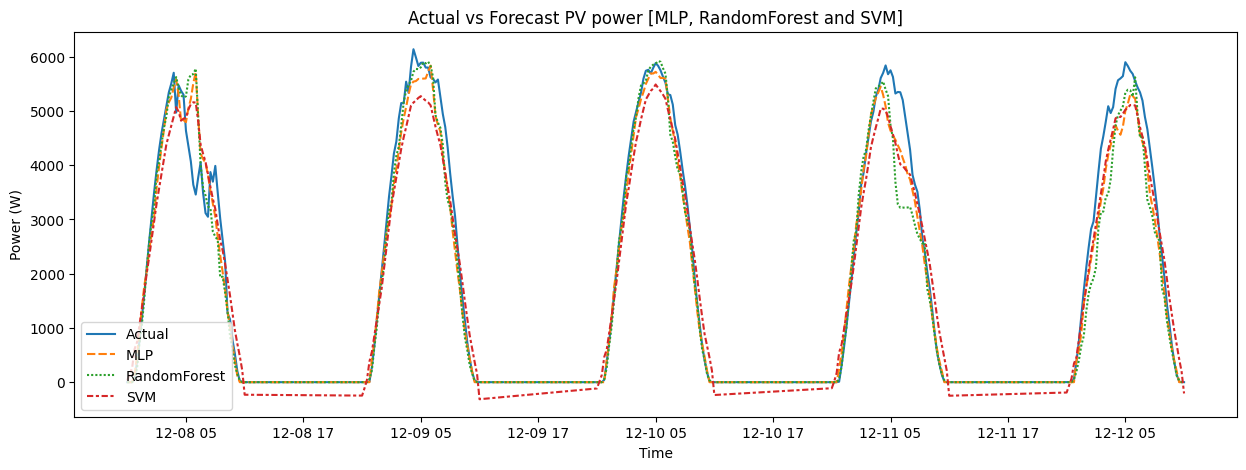

In [40]:
plt.figure(figsize=(15,5))
sns.lineplot(data=NWP_model_results['2019-12-08':'2019-12-12'])
plt.title('Actual vs Forecast PV power [MLP, RandomForest and SVM]')
plt.xlabel('Time')
plt.ylabel('Power (W)');

### 2. PV energy

#### 2.1 MLP

In [42]:
MLP_kWh = calculating_kWh(NWP_model_results['Actual'], NWP_model_results['MLP'].reset_index()['MLP'])
MLP_kWh.shape

(336, 2)

In [43]:
MLP_kWh.head()

,y_true_kWh,y_preds_kWh
2019-01-01,41.724,35.049
2019-01-02,43.265,35.896
2019-01-03,18.531,24.807
2019-01-04,19.804,22.536
2019-01-05,6.895,20.153


In [44]:
MLP_kWh.isna().sum()

y_true_kWh     0
y_preds_kWh    0
dtype: int64

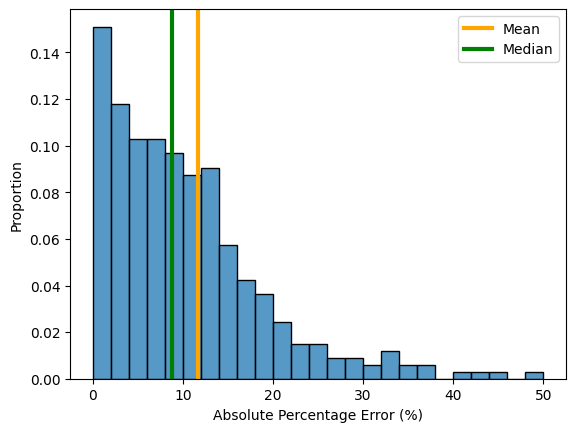

In [45]:
APE_MLP_kWh = APE(MLP_kWh['y_preds_kWh'], MLP_kWh['y_true_kWh'])

# Plot the APEs in histogram
plot_histogram(APE_MLP_kWh, 2, 50)

In [46]:
print(f'Max APE of MLP_kWh = {np.max(APE_MLP_kWh)}')
print(f'Min APE of MLP_kWh = {np.min(APE_MLP_kWh)}')
print(f'Mean APE of MLP_kWh = {np.mean(APE_MLP_kWh):.2f}')
print(f'Median APE of MLP_kWh = {np.median(APE_MLP_kWh):.2f}')

MLP_kWh_metrics = {'Max':np.max(APE_MLP_kWh), 'Min':np.min(APE_MLP_kWh), 
                   'Mean':np.mean(APE_MLP_kWh), 'Median':np.median(APE_MLP_kWh)}
MLP_kWh_metrics

Max APE of MLP_kWh = 192.28
Min APE of MLP_kWh = 0.01
Mean APE of MLP_kWh = 11.69
Median APE of MLP_kWh = 8.78


{'Max': 192.28, 'Min': 0.01, 'Mean': 11.687738095238094, 'Median': 8.775}

#### 2.2 RandomForest

In [47]:
RF_kWh = calculating_kWh(NWP_model_results['Actual'], NWP_model_results['RandomForest'].reset_index()['RandomForest'])
RF_kWh.shape

(336, 2)

In [48]:
RF_kWh.isna().sum()

y_true_kWh     0
y_preds_kWh    0
dtype: int64

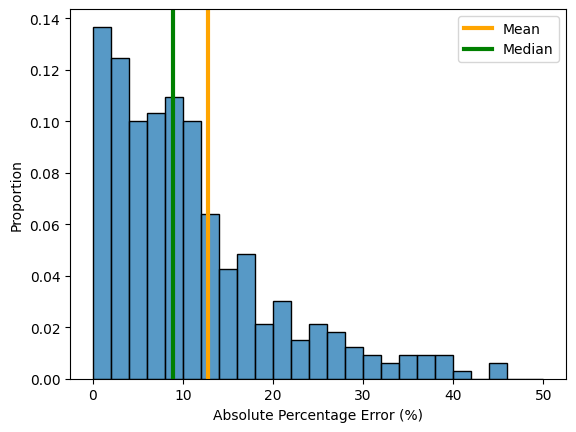

In [49]:
APE_RF_kWh = APE(RF_kWh['y_preds_kWh'], RF_kWh['y_true_kWh'])

# Plot the APEs in histogram
plot_histogram(APE_RF_kWh, 2, 50)

In [50]:
print(f'Max APE of RF_kWh = {np.max(APE_RF_kWh)}')
print(f'Min APE of RF_kWh = {np.min(APE_RF_kWh)}')
print(f'Mean APE of RF_kWh = {np.mean(APE_RF_kWh):.2f}')
print(f'Median APE of RF_kWh = {np.median(APE_RF_kWh):.2f}')

RF_kWh_metrics = {'Max':np.max(APE_RF_kWh), 'Min':np.min(APE_RF_kWh), 
                  'Mean':np.mean(APE_RF_kWh), 'Median':np.median(APE_RF_kWh)}
RF_kWh_metrics

Max APE of RF_kWh = 215.2
Min APE of RF_kWh = 0.15
Mean APE of RF_kWh = 12.80
Median APE of RF_kWh = 8.93


{'Max': 215.2, 'Min': 0.15, 'Mean': 12.800565476190476, 'Median': 8.925}

#### 2.3 SVM

In [51]:
SVM_kWh = calculating_kWh(NWP_model_results['Actual'], NWP_model_results['SVM'].reset_index()['SVM'])
SVM_kWh.shape

(336, 2)

In [52]:
SVM_kWh.isna().sum()

y_true_kWh     0
y_preds_kWh    0
dtype: int64

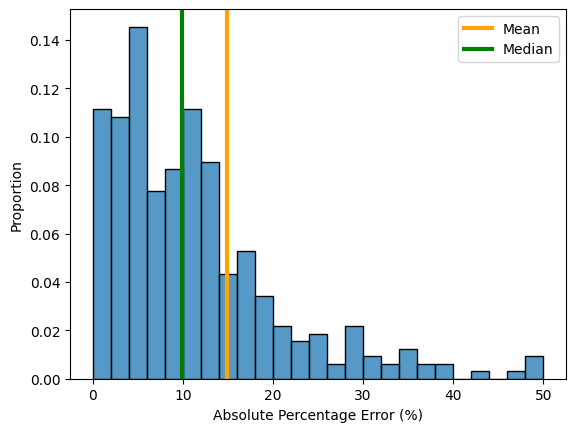

In [53]:
APE_SVM_kWh = APE(SVM_kWh['y_preds_kWh'], SVM_kWh['y_true_kWh'])

# Plot the APEs in histogram
plot_histogram(APE_SVM_kWh, 2, 50)

In [54]:
print(f'Max APE of SVM_kWh = {np.max(APE_SVM_kWh)}')
print(f'Min APE of SVM_kWh = {np.min(APE_SVM_kWh)}')
print(f'Mean APE of SVM_kWh = {np.mean(APE_SVM_kWh):.2f}')
print(f'Median APE of SVM_kWh = {np.median(APE_SVM_kWh):.2f}')

SVM_kWh_metrics = {'Max':np.max(APE_SVM_kWh), 'Min':np.min(APE_SVM_kWh), 
                  'Mean':np.mean(APE_SVM_kWh), 'Median':np.median(APE_SVM_kWh)}
SVM_kWh_metrics

Max APE of SVM_kWh = 234.95
Min APE of SVM_kWh = 0.04
Mean APE of SVM_kWh = 14.93
Median APE of SVM_kWh = 9.91


{'Max': 234.95,
 'Min': 0.04,
 'Mean': 14.932113095238094,
 'Median': 9.905000000000001}

### Summary of PV power

In [55]:
NWP_model_scores

,MAE,RMSE,MBE,NMAE_installed,NRMSE_installed,NMAE_avg,NRMSE_avg
MLP,694.76,999.50,-36.30,6.95,9.99,22.71,32.67
RF,690.03,1008.22,58.85,6.90,10.08,22.55,32.95
SVM,784.07,1077.07,112.13,7.84,10.77,25.63,35.20


### Summary of PV energy

In [56]:
pd.DataFrame([MLP_kWh_metrics, RF_kWh_metrics, SVM_kWh_metrics], index=['MLP', 'RF','SVM']).round(2)

,Max,Min,Mean,Median
MLP,192.28,0.01,11.69,8.78
RF,215.20,0.15,12.80,8.93
SVM,234.95,0.04,14.93,9.91


In [57]:
kWh_results_test_data = pd.concat([MLP_kWh, RF_kWh['y_preds_kWh'], SVM_kWh['y_preds_kWh']], axis=1)
kWh_results_test_data.columns = ['Actual_kWh', 'MLP', 'RF', 'SVM']
kWh_results_test_data.head(5)

,Actual_kWh,MLP,RF,SVM
2019-01-01,41.724,35.049,37.119,34.340
2019-01-02,43.265,35.896,37.241,35.488
2019-01-03,18.531,24.807,24.086,25.940
2019-01-04,19.804,22.536,23.209,25.490
2019-01-05,6.895,20.153,21.733,23.095


In [58]:
kWh_results_test_data.to_csv('./data_for_report/kWh_historical_data (go_beyond_models).csv')

### --------------------------------------------------------------------------------------------------------------------------------------------------------
### --------------------------------------------------------------------------------------------------------------------------------------------------------
### --------------------------------------------------------------------------------------------------------------------------------------------------------
### --------------------------------------------------------------------------------------------------------------------------------------------------------

# Import Numerical Weather Prediction (NWP) data

In [59]:
ori_NWP_df = pd.read_csv('../Data/fore_data.csv', 
                         index_col='timestamp_local', encoding='utf-8-sig', parse_dates=['timestamp_local'])
ori_NWP_df.shape

(191, 35)

# Daytime filter

In [60]:
import datetime

# Standard filter
NWP_df = ori_NWP_df[(ori_NWP_df.index.time >= datetime.time(6,0)) & (ori_NWP_df.index.time <= datetime.time(18,0))]

# Advance filter and no filter
# NWP_df = ori_NWP_df
NWP_df.shape

(104, 35)

In [61]:
NWP_df.head(30).index

DatetimeIndex(['2023-03-17 06:00:00', '2023-03-17 07:00:00',
               '2023-03-17 08:00:00', '2023-03-17 09:00:00',
               '2023-03-17 10:00:00', '2023-03-17 11:00:00',
               '2023-03-17 12:00:00', '2023-03-17 13:00:00',
               '2023-03-17 14:00:00', '2023-03-17 15:00:00',
               '2023-03-17 16:00:00', '2023-03-17 17:00:00',
               '2023-03-17 18:00:00', '2023-03-18 06:00:00',
               '2023-03-18 07:00:00', '2023-03-18 08:00:00',
               '2023-03-18 09:00:00', '2023-03-18 10:00:00',
               '2023-03-18 11:00:00', '2023-03-18 12:00:00',
               '2023-03-18 13:00:00', '2023-03-18 14:00:00',
               '2023-03-18 15:00:00', '2023-03-18 16:00:00',
               '2023-03-18 17:00:00', '2023-03-18 18:00:00',
               '2023-03-19 06:00:00', '2023-03-19 07:00:00',
               '2023-03-19 08:00:00', '2023-03-19 09:00:00'],
              dtype='datetime64[ns]', name='timestamp_local', freq=None)

## Data preprocessing

In [62]:
'''
Split X and y
'''
NWP_X = NWP_df[X_cols]
NWP_y = NWP_df['PV_Power']
NWP_X.shape, NWP_y.shape

((104, 12), (104,))

In [63]:
'''
OneHot Encoding and Standardize numerical data
'''

std_NWP_X = ct.transform(NWP_X)
std_NWP_X.shape

(104, 12)

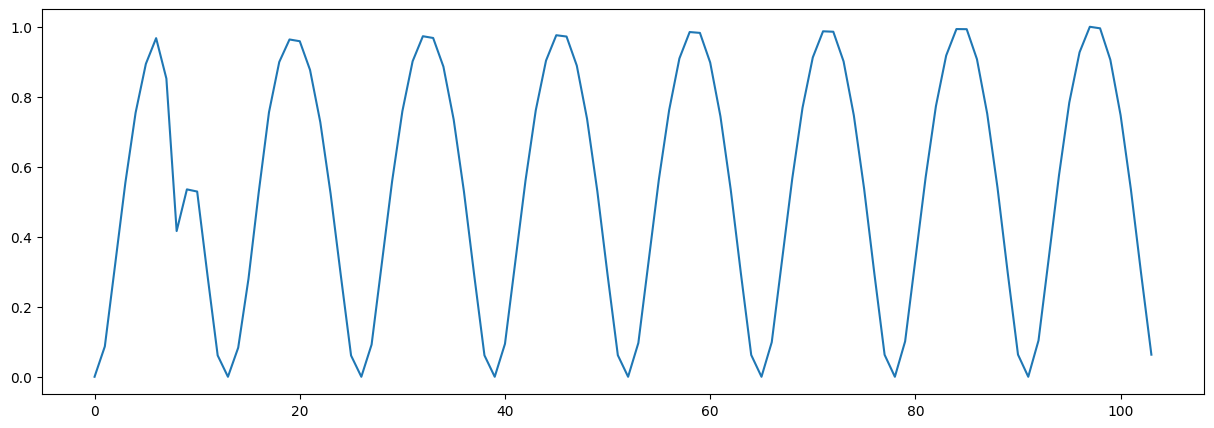

In [64]:
## Verify the input data before making prediction. 
plt.figure(figsize=(15,5))
sns.lineplot(std_NWP_X[:, 0]);

## Load models

In [65]:
# import tensorflow as tf
# from tensorflow import keras
# from joblib import dump, load

# # Models
# MLP_model = keras.models.load_model('saved_models/new_MLP_new_split')
# RF_model = load('saved_models/new_RF_model.joblib')
# SVR_model = load('saved_models/new_SVR_model.joblib')

## PV output forecasting with NWP

In [66]:
# MLP
fore_MLP_result = forecasting_result(MLP_model, std_NWP_X)
print(f'MLP forecast shape: {fore_MLP_result.shape} \n')

4/4 [==============================] - 4s 513ms/step
MLP forecast shape: (104,) 



In [67]:
# Random Forest
fore_RF_result = forecasting_result(RF_model, std_NWP_X)
print(f'RF forecast shape: {fore_RF_result.shape} \n')

# SVR
fore_SVR_result = forecasting_result(SVR_model, std_NWP_X)
print(f'SVR forecast shape: {fore_SVR_result.shape} \n')

RF forecast shape: (104,) 

SVR forecast shape: (104,) 



### 1. `MLP`

In [68]:
forecast_MLP_scores = show_scores(fore_MLP_result, NWP_y)
# plot_pv(fore_MLP_result, NWP_y, 'MLP', {'year':2023, 'month':3, 'start':17, 'end':24})

Mean Absolute Error = 701.31 W 
Root Mean Squared Error = 950.28 W 
Mean Bias Error = 491.82 W 
 
Normalized_MAE (installed_Power) = 7.01% 
Normalized_RMSE (installed_Power) = 9.50% 
 
Normalized_MAE (avg_Power) = 22.42% 
Normalized_RMSE (avg_Power) = 30.37% 
 
Peak PV output power (from y_test) = 6623.48 W 
Average PV output power (from y_test) = 3128.71 W


### 2. `Random Forest`

In [69]:
forecast_RF_scores = show_scores(fore_RF_result, NWP_y)
# plot_pv(fore_RF_result, NWP_y, 'RF', {'year':2023, 'month':3, 'start':17, 'end':24})

Mean Absolute Error = 648.99 W 
Root Mean Squared Error = 903.13 W 
Mean Bias Error = 463.12 W 
 
Normalized_MAE (installed_Power) = 6.49% 
Normalized_RMSE (installed_Power) = 9.03% 
 
Normalized_MAE (avg_Power) = 20.74% 
Normalized_RMSE (avg_Power) = 28.87% 
 
Peak PV output power (from y_test) = 6623.48 W 
Average PV output power (from y_test) = 3128.71 W


### 3. `SVM`

In [70]:
forecast_SVR_scores = show_scores(fore_SVR_result, NWP_y)
# plot_pv(fore_SVR_result, NWP_y, 'SVR', {'year':2023, 'month':3, 'start':17, 'end':24})

Mean Absolute Error = 746.33 W 
Root Mean Squared Error = 1000.28 W 
Mean Bias Error = 678.81 W 
 
Normalized_MAE (installed_Power) = 7.46% 
Normalized_RMSE (installed_Power) = 10.00% 
 
Normalized_MAE (avg_Power) = 23.85% 
Normalized_RMSE (avg_Power) = 31.97% 
 
Peak PV output power (from y_test) = 6623.48 W 
Average PV output power (from y_test) = 3128.71 W


## Evaluating the models

### 1. PV power

In [71]:
score_table_forecast = pd.DataFrame([forecast_MLP_scores, forecast_RF_scores, forecast_SVR_scores], 
                                    index=['MLP','RandomForest', 'SVR'])
score_table_forecast

,MAE,RMSE,MBE,NMAE_installed,NRMSE_installed,NMAE_avg,NRMSE_avg
MLP,701.31,950.28,491.82,7.01,9.50,22.42,30.37
RandomForest,648.99,903.13,463.12,6.49,9.03,20.74,28.87
SVR,746.33,1000.28,678.81,7.46,10.00,23.85,31.97


In [72]:
fore_data_results = pd.concat([NWP_y.reset_index(), pd.Series(fore_MLP_result), 
                            pd.Series(fore_RF_result), pd.Series(fore_SVR_result)], axis=1)

fore_data_results = fore_data_results.set_index('timestamp_local')
fore_data_results.columns = ['PV_Power', 'MLP', 'RandomForest', 'SVM']
fore_data_results.head(30)

,PV_Power,MLP,RandomForest,SVM
timestamp_local,,,,
2023-03-17 06:00:00,35.4125,0.000000,0.081647,1.940461
2023-03-17 07:00:00,894.3154,540.550598,378.045804,863.255193
2023-03-17 08:00:00,1531.7964,2082.662842,1983.722772,2363.555545
2023-03-17 09:00:00,3523.5237,3652.768311,3927.821507,3962.821243
2023-03-17 10:00:00,4984.8999,5305.624023,5491.407773,5362.863302
2023-03-17 11:00:00,4560.9585,6106.933594,6164.766016,6289.870073
2023-03-17 12:00:00,4374.4360,6449.033203,6513.435020,6660.141306
2023-03-17 13:00:00,4167.5938,5932.503906,5896.181132,5771.247541
2023-03-17 14:00:00,3844.1541,5214.258301,3763.687509,3925.940141


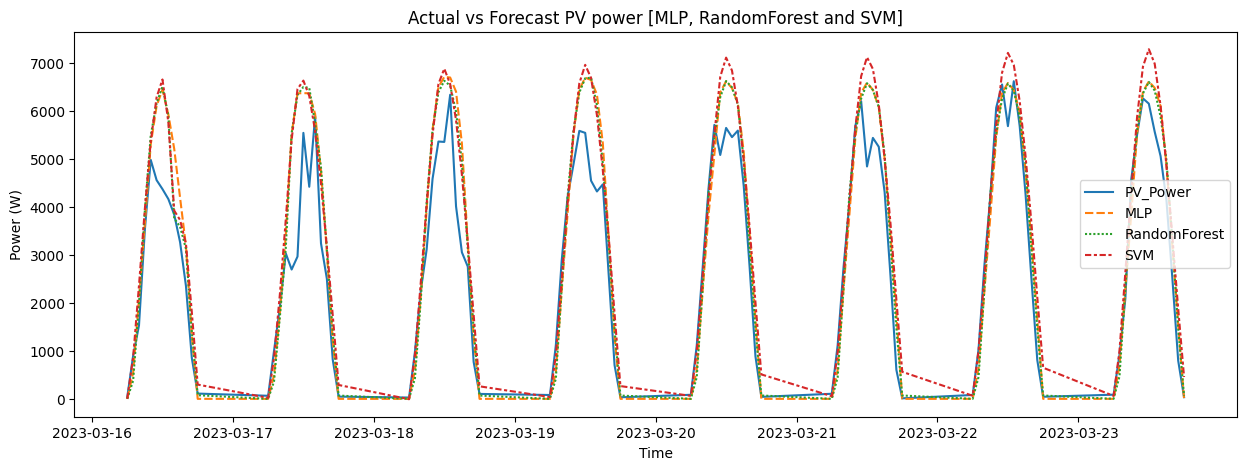

In [73]:
plt.figure(figsize=(15,5))
sns.lineplot(data=fore_data_results)
plt.title('Actual vs Forecast PV power [MLP, RandomForest and SVM]')
plt.xlabel('Time')
plt.ylabel('Power (W)');

### Calculate Absolute Percentage Error (APE) of PV_power of each timestamp

In [74]:
fore_data_results['APE_MLP'] = APE(fore_data_results['MLP'], fore_data_results['PV_Power'])
fore_data_results['APE_RF'] = APE(fore_data_results['RandomForest'], fore_data_results['PV_Power'])
fore_data_results['APE_SVM'] = APE(fore_data_results['SVM'], fore_data_results['PV_Power'])
fore_data_results

,PV_Power,MLP,RandomForest,SVM,APE_MLP,APE_RF,APE_SVM
timestamp_local,,,,,,,
2023-03-17 06:00:00,35.4125,0.000000,0.081647,1.940461,100.00,99.77,94.52
2023-03-17 07:00:00,894.3154,540.550598,378.045804,863.255193,39.56,57.73,3.47
2023-03-17 08:00:00,1531.7964,2082.662842,1983.722772,2363.555545,35.96,29.50,54.30
2023-03-17 09:00:00,3523.5237,3652.768311,3927.821507,3962.821243,3.67,11.47,12.47
2023-03-17 10:00:00,4984.8999,5305.624023,5491.407773,5362.863302,6.43,10.16,7.58
...,...,...,...,...,...,...,...
2023-03-24 14:00:00,5062.4663,6104.105469,5887.961438,6109.714202,20.58,16.31,20.69
2023-03-24 15:00:00,4141.4067,4885.469238,4975.955839,4862.815768,17.97,20.15,17.42
2023-03-24 16:00:00,2525.0273,3193.689209,3313.256082,3389.376263,26.48,31.22,34.23


Max APE = 189.94
Min APE = 0.42
Mean APE = 41.49
Median APE = 26.09


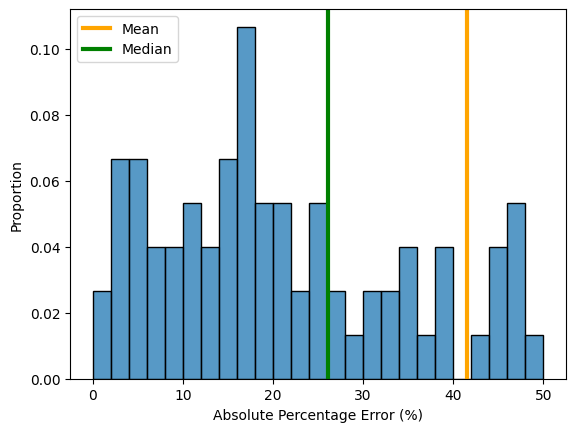

In [75]:
plot_histogram(fore_data_results['APE_MLP'], 2, 50)

print(f'Max APE = {np.max(fore_data_results["APE_MLP"])}')
print(f'Min APE = {np.min(fore_data_results["APE_MLP"])}')
print(f'Mean APE = {np.mean(fore_data_results["APE_MLP"]):.2f}')
print(f'Median APE = {np.median(fore_data_results["APE_MLP"]):.2f}')

Max APE = 540.53
Min APE = 0.04
Mean APE = 42.49
Median APE = 23.93


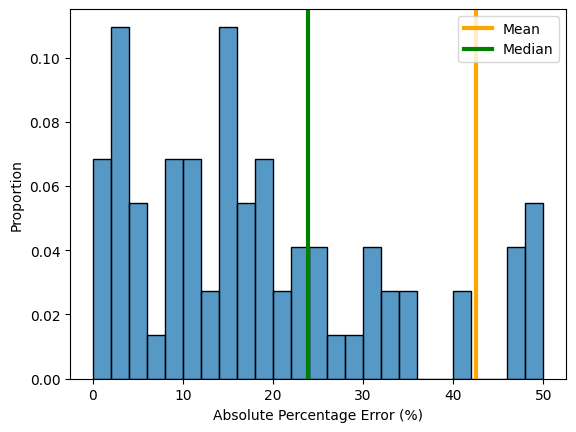

In [76]:
plot_histogram(fore_data_results['APE_RF'], 2, 50)

print(f'Max APE = {np.max(fore_data_results["APE_RF"])}')
print(f'Min APE = {np.min(fore_data_results["APE_RF"])}')
print(f'Mean APE = {np.mean(fore_data_results["APE_RF"]):.2f}')
print(f'Median APE = {np.median(fore_data_results["APE_RF"]):.2f}')

Max APE = 5096.54
Min APE = 0.09
Mean APE = 132.57
Median APE = 25.47


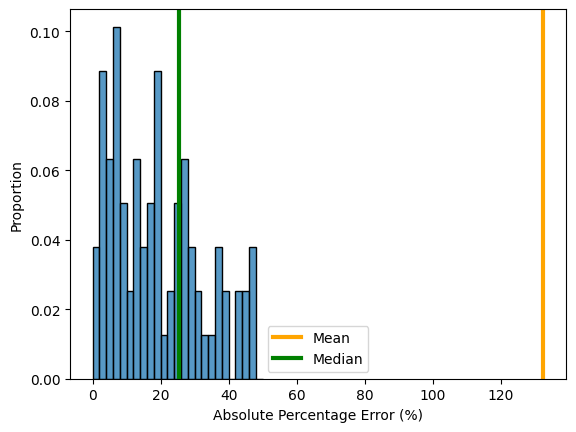

In [77]:
plot_histogram(fore_data_results['APE_SVM'], 2, 50)

print(f'Max APE = {np.max(fore_data_results["APE_SVM"])}')
print(f'Min APE = {np.min(fore_data_results["APE_SVM"])}')
print(f'Mean APE = {np.mean(fore_data_results["APE_SVM"]):.2f}')
print(f'Median APE = {np.median(fore_data_results["APE_SVM"]):.2f}')

In [78]:
fore_data_results.shape

(104, 7)

In [79]:
'''
Save the results in csv. 
'''
fore_data_results.to_csv('data_for_report/NWP_data (go_beyond_models).csv')

### 2. PV energy

#### 2.1 MLP

In [80]:
fore_MLP_kWh = calculating_kWh(fore_data_results['PV_Power'], fore_data_results['MLP'].reset_index()['MLP'])
fore_MLP_kWh.shape

(8, 2)

In [81]:
fore_MLP_kWh.isna().sum()

y_true_kWh     0
y_preds_kWh    0
dtype: int64

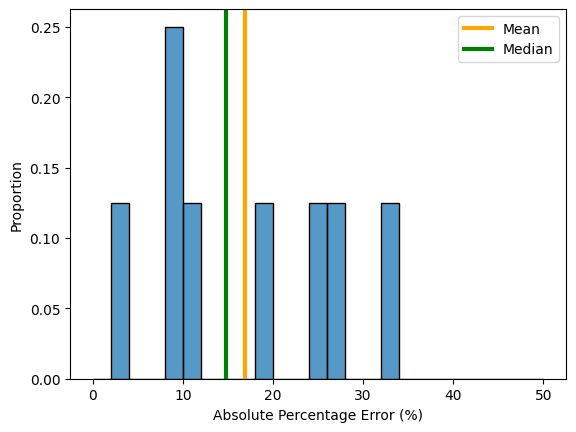

In [82]:
APE_fore_MLP_kWh = APE(fore_MLP_kWh['y_preds_kWh'], fore_MLP_kWh['y_true_kWh'])

# Plot the APEs in histogram
plot_histogram(APE_fore_MLP_kWh, 2, 50)

#### 2.2 RandomForest

In [83]:
fore_RF_kWh = calculating_kWh(fore_data_results['PV_Power'], 
                              fore_data_results['RandomForest'].reset_index()['RandomForest'])
fore_RF_kWh.shape

(8, 2)

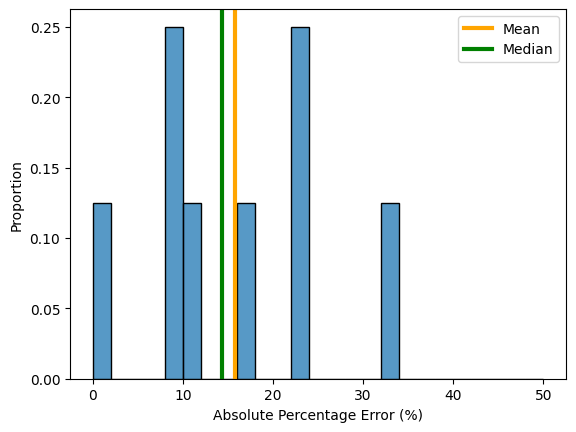

In [84]:
APE_fore_RF_kWh = APE(fore_RF_kWh['y_preds_kWh'], fore_RF_kWh['y_true_kWh'])

# Plot the APEs in histogram
plot_histogram(APE_fore_RF_kWh, 2, 50)

#### 2.3 SVM

In [85]:
fore_SVM_kWh = calculating_kWh(fore_data_results['PV_Power'], 
                              fore_data_results['SVM'].reset_index()['SVM'])
fore_SVM_kWh.shape

(8, 2)

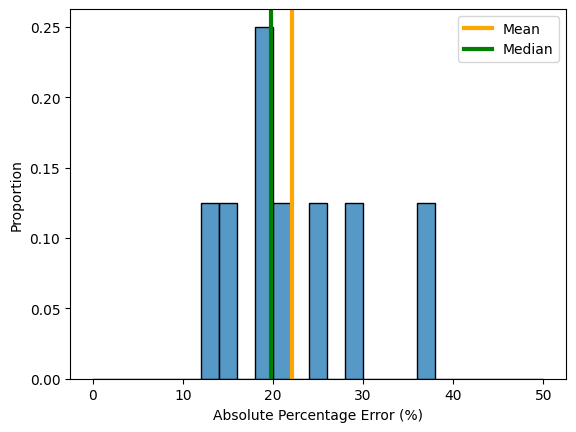

In [86]:
APE_fore_SVM_kWh = APE(fore_SVM_kWh['y_preds_kWh'], fore_SVM_kWh['y_true_kWh'])

# Plot the APEs in histogram
plot_histogram(APE_fore_SVM_kWh, 2, 50)

In [87]:
fore_MLP_kWh_metrics = {'Max':np.max(APE_fore_MLP_kWh), 'Min':np.min(APE_fore_MLP_kWh), 
                        'Mean':np.mean(APE_fore_MLP_kWh), 'Median':np.median(APE_fore_MLP_kWh)}

fore_RF_kWh_metrics = {'Max':np.max(APE_fore_RF_kWh), 'Min':np.min(APE_fore_RF_kWh), 
                       'Mean':np.mean(APE_fore_RF_kWh), 'Median':np.median(APE_fore_RF_kWh)}

fore_SVM_kWh_metrics = {'Max':np.max(APE_fore_SVM_kWh), 'Min':np.min(APE_fore_SVM_kWh), 
                        'Mean':np.mean(APE_fore_SVM_kWh), 'Median':np.median(APE_fore_SVM_kWh)}

pd.DataFrame([fore_MLP_kWh_metrics, fore_RF_kWh_metrics, fore_SVM_kWh_metrics], index=['MLP', 'RF','SVM']).round(2)

,Max,Min,Mean,Median
MLP,32.89,2.00,16.93,14.80
RF,32.48,1.90,15.80,14.38
SVM,37.03,12.06,22.06,19.84


In [88]:
score_table_forecast

,MAE,RMSE,MBE,NMAE_installed,NRMSE_installed,NMAE_avg,NRMSE_avg
MLP,701.31,950.28,491.82,7.01,9.50,22.42,30.37
RandomForest,648.99,903.13,463.12,6.49,9.03,20.74,28.87
SVR,746.33,1000.28,678.81,7.46,10.00,23.85,31.97


In [89]:
kWh_results_NWP_data = pd.concat([fore_MLP_kWh, fore_RF_kWh['y_preds_kWh'], fore_SVM_kWh['y_preds_kWh']], axis=1)
kWh_results_NWP_data.columns = ['Actual_kWh', 'MLP', 'RF', 'SVM']
kWh_results_NWP_data

,Actual_kWh,MLP,RF,SVM
2023-03-17,34.426,43.997,42.267,44.117
2023-03-18,34.102,45.319,45.179,46.730
2023-03-19,38.675,48.533,47.297,48.562
2023-03-20,40.930,48.337,48.056,49.247
2023-03-21,43.860,47.678,47.677,50.859
2023-03-22,42.907,47.839,47.771,51.210
2023-03-23,46.328,47.254,47.210,51.914
2023-03-24,43.662,47.579,47.812,51.548


In [90]:
kWh_results_NWP_data.to_csv('./data_for_report/kWh_NWP_data (go_beyond_models).csv')